# Habitable Planet Hunter: Data Imputation
**Author:** Krishna Sikheriya (Krishna200608)  

---

Our dataset of exoplanets contains gaps. We have missing values for critical physical properties like **Planet Mass** and **Radius**. Simply deleting these rows would mean throwing away potential habitable worlds, but filling them with a simple average (mean) would create "average" planets that don't exist in reality.

**The Solution:**
We use **MICE (Multivariate Imputation by Chained Equations)**. Think of this as an AI detective: it looks at known correlations (e.g., "Planets with this gravity usually have this density") to intelligently estimate the missing pieces.

**Key Improvements in This Version:**
1.  **Physics Enforcement:** We strictly forbid negative values. A planet cannot have -5 Earth Radii!
2.  **Dynamic Adaptation:** The pipeline now automatically detects and drops columns that are 100% empty, preventing crashes.
3.  **Strict Type Safety:** The plotting code is updated to satisfy modern strict type-checkers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

# Set a clean visual style for our charts
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (12, 6)

### **Step 1: Loading & Cleaning the Data**
Real-world data is messy. Before we even start imputing, we need to check for "Dead Columns"—features that have absolutely zero data. If we feed these to our algorithm, it will crash because it has nothing to learn from.

We also strictly limit our dataset to the **30 Approved Features** defined in the project scope.

In [2]:
# 1. Load Data
df = pd.read_csv('../../datasets/full_data.csv')

# 2. Define the 30 Approved Features (Project Standard)
approved_features = [
    'P_MASS', 'P_RADIUS', 'P_DENSITY', 'P_GRAVITY', 'P_ESCAPE', 'P_TYPE',
    'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_INCLINATION',
    'P_OMEGA', 'P_PERIASTRON', 'P_APASTRON', 'P_IMPACT_PARAMETER', 'P_HILL_SPHERE',
    'S_MASS', 'S_RADIUS', 'S_LUMINOSITY', 'S_TEMPERATURE', 'S_AGE',
    'S_METALLICITY', 'S_LOG_G', 'S_TYPE', 'S_MAG', 'S_DISC', 'S_MAGNETIC_FIELD',
    'S_SNOW_LINE', 'S_TIDAL_LOCK', 'P_DETECTION', 'P_DISTANCE'
]

# 3. Filter to available columns
existing_cols = [col for col in approved_features if col in df.columns]
df_selected = df[existing_cols].copy()

# 4. Auto-Drop Dead Columns
empty_cols = df_selected.columns[df_selected.isnull().all()].tolist()
if empty_cols:
    print(f'Warning: Dropping 100% empty columns to prevent pipeline crash: {empty_cols}')
    df_selected = df_selected.drop(columns=empty_cols)

print(f'Final Dataset Shape for Imputation: {df_selected.shape}')

Final Dataset Shape for Imputation: (4048, 28)


### **Step 2: Building the "Physics-Aware" Pipeline**
This is the brain of the operation. We set up two parallel tracks:
1.  **Categorical Track:** Handles text data (like "P_TYPE"). We convert these to numbers so the math works.
2.  **Numerical Track (The Important Part):** We use MICE (`IterativeImputer`). 

**Crucial Fix:** We added `min_value=0`. This tells the model: *"Whatever mathematical trend you find, do NOT predict a negative mass or radius."*

In [ ]:
# Identify types dynamically based on what remained after cleaning
categorical_cols = df_selected.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Numerical Pipeline: MICE with Physics Constraints
num_pipeline = Pipeline([
    ('imputer', IterativeImputer(
        max_iter=50,
        random_state=42,
        initial_strategy='median',
        min_value=0,  
        sample_posterior=True 
    ))
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
], verbose_feature_names_out=False)

print('Pipeline constructed successfully.')

Pipeline constructed successfully.


### **Step 3: Executing the Imputation & The "Safety Lock"**
We run the pipeline. But because floating-point math is never perfect, we add one final **Safety Lock**: `clip(lower=0)`. 

This guarantees that even if the model predicts `-0.000001` due to a tiny calculation error, it gets forced to `0.0`. This is standard engineering practice for physical data.

In [ ]:
print('Running Imputation... (This ensures no negative physics)')
data_imputed = preprocessor.fit_transform(df_selected)

# Dynamic Column Recovery
new_columns = preprocessor.get_feature_names_out()

df_final = pd.DataFrame(data_imputed, columns=new_columns, index=df_selected.index)


df_final[numerical_cols] = df_final[numerical_cols].clip(lower=0)


final_cols_ordered = [col for col in approved_features if col in df_final.columns]
df_final = df_final[final_cols_ordered]

print(f'Imputation Complete. Final Shape: {df_final.shape}')
print(f'Remaining missing values: {df_final.isnull().sum().sum()}')

Running Imputation... (This ensures no negative physics)
Imputation Complete. Final Shape: (4048, 28)
Remaining missing values: 0


### **Step 4: Visual Proof (KDE Plot)**
We compare the **Original (Blue)** data with our **Imputed (Red)** data. 

**Success Criteria:**
1.  The Red line should follow the shape of the Blue line (preserving the data's "personality").
2.  The Red line must **NOT** exist below 0 on the X-axis.

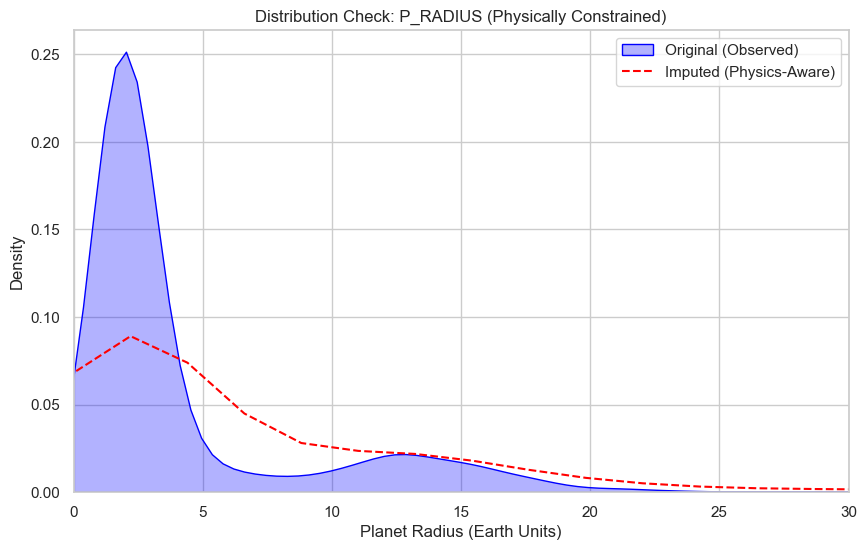

In [ ]:
target_feature = 'P_RADIUS'

if target_feature in df_final.columns:
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(x=df_selected[target_feature].dropna(), label='Original (Observed)', fill=True, color='blue', alpha=0.3)
    sns.kdeplot(x=df_final[target_feature], label='Imputed (Physics-Aware)', linestyle='--', color='red')

    plt.title(f'Distribution Check: {target_feature} (Physically Constrained)')
    plt.xlabel('Planet Radius (Earth Units)')
    plt.xlim(0, 30) 
    plt.legend()
    plt.show()
else:
    print(f'{target_feature} was dropped or not present.')

### **Step 5: Saving the Gold Standard Data**
Now that we've verified the data is clean, complete, and physically valid, we save it for the next team member.

In [7]:
df_final.to_csv('final-imputed_data.csv', index=False)
print('Success: Saved to final-imputed_data.csv')

Success: Saved to final-imputed_data.csv
